# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [3]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [6]:
# normalizujemy teksty na potrzeby dalszego przetwarzania

def preprocess_text(text):
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    # usuwamy znaki interpunkcyjne
    # usuwamy wszystkie liczby
    # podmieniamy wszystkie wielkie litery
    # dzielimy na tokeny
    # usuwamy stopwords
    text = ' '.join(text.split())
    text = text.translate(str.maketrans('', '', punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.lower()
    text = text.split()
    text = [w for w in text if not w in STOPWORDS]
    return text

def stem_texts(corpus):
    stemmer = SnowballStemmer(language='english') # przetestuj rozne stemmery
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [7]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think realli good team team realli special good thing group close brian schmetzer


In [8]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus):
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    result = []
    for text in corpus:
        result.extend(text)
    result = sorted(set(result))
    return result

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41849


In [12]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus, wordlist):
    document_frequencies = {word: 0 for word in wordlist}
    for text in corpus:
        for word in set(text):
            document_frequencies[word] += 1
    return document_frequencies

document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [13]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus, news_indices):
    term_frequencies = {news_id: {} for news_id in news_indices.keys()}
    for news_id, text in zip(news_indices, corpus):
        for word in text:
            term_frequencies[news_id][word] = term_frequencies[news_id].get(word, 0) + 1
    return term_frequencies

term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [14]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

{'think': 1,
 'realli': 2,
 'good': 2,
 'team': 2,
 'special': 1,
 'thing': 1,
 'group': 1,
 'close': 1,
 'brian': 1,
 'schmetzer': 1}

In [15]:
# obliczamy metryke tf_idf

def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    tf_idf = {news_id: {word: 0 for word in term_frequency[news_id].keys()} for news_id in term_frequency.keys()}
    for news_id in term_frequency.keys():
        for word in term_frequency[news_id].keys():
            tf_idf[news_id][word] = term_frequency[news_id][word] * math.log(corpus_size/document_frequency[word])
    return tf_idf

tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [16]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.360459856758821,
 'realli': 9.707261090572182,
 'good': 8.085400658139525,
 'team': 6.157356388748834,
 'special': 4.765161897298483,
 'thing': 4.111693200556713,
 'group': 4.261685870235309,
 'close': 3.9244235881453897,
 'brian': 5.624739267315748,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [18]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_distance(tf_idf, id1, id2):
    distance = 0

    # metryka euklidesowa
    for word in set(tf_idf[id1].keys()) | set(tf_idf[id2].keys()):
        val1 = tf_idf[id1].get(word, 0)
        val2 = tf_idf[id2].get(word, 0)
        distance += (val1 - val2)**2

    distance = math.sqrt(distance)

    # metryka cosinusowa
#     val1_norm = 1
#     val2_norm = 1

#     for word in set(tf_idf[id1].keys()) | set(tf_idf[id2].keys()):
#         val1 = tf_idf[id1].get(word, 0)
#         val2 = tf_idf[id2].get(word, 0)

#         distance += val1 * val2

#         val1_norm += val1 ** 2
#         val2_norm += val2 ** 2

#     val1_norm = math.sqrt(val1_norm)
#     val2_norm = math.sqrt(val2_norm)

#     distance = distance / (val1_norm * val2_norm)

    return distance

calculate_distance(tf_idf, news_ids[2], news_ids[1])

42.49503805496136

In [19]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [20]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf, n_id, k):
    distances = {}
    for news_id in tf_idf.keys():
        if news_id != n_id:
            distances[news_id] = calculate_distance(tf_idf, news_id, n_id)
    return dict(sorted(distances.items(), key=lambda x:x[1], reverse=True)[:k]).keys()

def print_k_most_similar_news(tf_idf, n_id, k, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [21]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:
    average_vector = defaultdict(float)

    if not news_ids:
        return average_vector

    for news_id in news_ids:
        for word, value in tf_idf[news_id].items():
            average_vector[word] += value

    for word in average_vector:
        average_vector[word] /= len(news_ids)

    return dict(average_vector)

# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf, users_history) -> dict[str, list]:
    users_vectors = {}

    for user_id, history in users_history.items():
        users_vectors[user_id] = calculate_average_vector(tf_idf, history)

    return users_vectors

user_vectors = calculate_users_vectors(tf_idf, users_history)


In [22]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 1.267870955689801), ('plane', 1.1701285777724966), ('ditch', 1.0497982187039419), ('diaz', 0.9848359105446637), ('land', 0.8870284483240061), ('paula', 0.8214687066477994), ('acr', 0.8090445060145697), ('ventura', 0.7780260164933531), ('mcconnel', 0.76945001209976), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailston', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.6912488475417629), ('chaser', 0.6756286236624416), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('report', 0.6253912485455763), ('twoweek', 0.6177050367898467), ('airlin', 0.611710355929694), ('story', 0.6009271210247275), ('contain', 0.5981148110881273), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('may', 0.5473113739405064), ('accord', 0.5430078051546358), ('ef', 0.5366350415870621), ('tanker', 0.5317069793379942), ('larg', 0.5301365597954284), ('mandatori', 0.5227667548412794), ('behind', 0.5071744020955066), ('mitch', 0.498135291

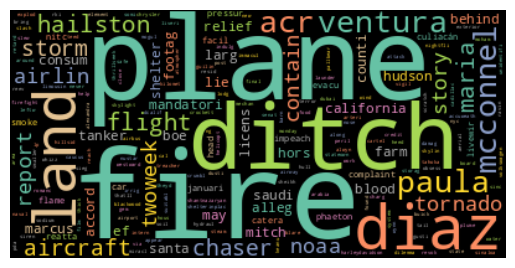

In [23]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

Historia użytkownika U53231: ['N58936', 'N15919', 'N11917', 'N2153', 'N55312', 'N13008', 'N41420', 'N24889', 'N719', 'N47485', 'N35259', 'N34124', 'N37720', 'N29924', 'N39498', 'N64049', 'N45794', 'N16715', 'N26122', 'N45535', 'N20091', 'N391', 'N12576', 'N53436', 'N41244', 'N5887', 'N49179', 'N55897']


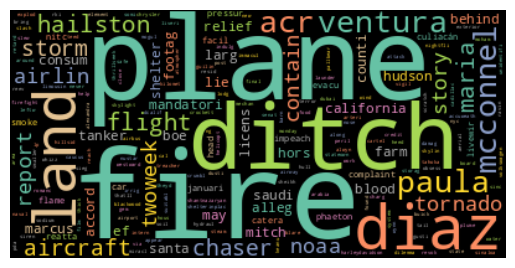

KeyboardInterrupt: 

In [28]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(tf_idf, user_id, news, users_history, k):
    user_vector = calculate_average_vector(tf_idf, users_history[user_id])

    similarities = {}
    for news_id in news:
        if news_id not in users_history[user_id]:
            similarities[news_id] = calculate_distance(tf_idf, news_id, news_id)

    sorted_similarities = dict(sorted(similarities.items(), key=lambda x: x[1]))

    return list(sorted_similarities.keys())[:k]

# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje
user_id = test_users[0]
print(f"Historia użytkownika {user_id}: {users_history[user_id]}")
plot_vector(user_vectors[user_id])
recommendations = recommend(tf_idf, user_id, news_ids, users_history, 5)
print(f"Rekomendacje dla użytkownika {user_id}")
for news_id in recommendations:
    print_news_entry(news_id, news)

## Część 6. - Ocena jakości

In [27]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1, v2):
    intersection = sum(min(v1.get(k, 0), v2.get(k, 0)) for k in set(v1) | set(v2))
    union = sum(max(v1.get(k, 0), v2.get(k, 0)) for k in set(v1) | set(v2))

    if union == 0:
        return 0

    return intersection / union

In [ ]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

raise NotImplementedError()